# Import

In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from causalml.inference.meta import (
    BaseDRLearner,
    BaseRLearner,
    BaseXLearner,
    BaseSLearner,
    BaseTLearner,
    BaseRClassifier,
    BaseXClassifier,
    BaseTClassifier,
    BaseSClassifier,
)
from causalml.inference.torch import CEVAE

from cate.dataset import Dataset
from cate.utils import PathLinker, Timer

/workspace/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pathlinker = PathLinker().data.criteo
timer = Timer()

# Functions

In [3]:
def to_rank(
    primary_key: pd.Series, score: pd.Series, ascending: bool = True
) -> pd.Series:
    df = pd.DataFrame({primary_key.name: primary_key, score.name: score}).set_index(
        primary_key.name, drop=True
    )
    df = df.sort_values(by=score.name, ascending=ascending)  # type: ignore
    df["rank"] = np.ceil(np.arange(len(df)) / len(df) * 100).astype(int)
    return df["rank"]

# Read Data

In [4]:
ds = Dataset.load(pathlinker.base)

# Model

In [5]:
# base_model = lgb.LGBMClassifier(importance_type="gain")
# names = [
#     "slearner",
#     "tlearner",
#     "xlearner",
#     "drlearner",
#     "rlearner",
#     "cevae",
# ]
# models = [
#     BaseSLearner(base_model),
#     BaseTLearner(base_model, base_model, base_model),
#     BaseXLearner(base_model, base_model, base_model),
#     BaseDRLearner(base_model, base_model, base_model, base_model),
#     BaseRLearner(base_model, base_model, base_model),
#     CEVAE(),
# ]

In [9]:
base_classifier = lgb.LGBMClassifier(importance_type="gain")
base_regressor = lgb.LGBMRegressor(importance_type="gain")
names = [
    "slearner",
    "tlearner",
    # "xlearner",
    # "rlearner",
    # "cevae",
]

models = [
    BaseSClassifier(base_classifier),
    BaseTClassifier(base_classifier),
    # BaseXClassifier(base_classifier, base_regressor),
    # BaseRClassifier(base_classifier, base_regressor),
    # CEVAE(),
]

In [10]:
np.int = int

In [11]:
pred_dfs = {}
skf = StratifiedKFold(5, shuffle=True, random_state=42)
for name, model in zip(names, models):
    _pred_dfs = []
    for train_idx, valid_idx in tqdm(skf.split(np.zeros(len(ds)), ds.y)):
        train_X = ds.X.iloc[train_idx]
        train_y = ds.y.iloc[train_idx].to_numpy().reshape(-1)
        train_w = ds.w.iloc[train_idx].to_numpy().reshape(-1)
        valid_X = ds.X.iloc[valid_idx]
        valid_y = ds.y.iloc[valid_idx].to_numpy().reshape(-1)
        valid_w = ds.w.iloc[valid_idx].to_numpy().reshape(-1)
        
        timer.start(f"fit {name}")
        model.fit(train_X, train_w, train_y)
        timer.stop(f"fit {name}")
        
        timer.start(f"predict {name}")
        pred = model.predict(valid_X)
        timer.stop(f"stop {name}")
        
        _pred_dfs.append(
            pd.DataFrame({"index": ds.y.index[valid_idx], "pred": pred.reshape(-1)})
        )  # type: ignore
    pred_dfs[name] = _pred_dfs

0it [00:00, ?it/s]

[LightGBM] [Info] Number of positive: 32619, number of negative: 11151054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.509372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1702
[LightGBM] [Info] Number of data points in the train set: 11183673, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002917 -> initscore=-5.834394
[LightGBM] [Info] Start training from score -5.834394


1it [00:29, 29.67s/it]

[LightGBM] [Info] Number of positive: 32619, number of negative: 11151054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.374104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1710
[LightGBM] [Info] Number of data points in the train set: 11183673, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002917 -> initscore=-5.834394
[LightGBM] [Info] Start training from score -5.834394


2it [00:54, 26.75s/it]

[LightGBM] [Info] Number of positive: 32620, number of negative: 11151054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.438686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1709
[LightGBM] [Info] Number of data points in the train set: 11183674, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002917 -> initscore=-5.834364
[LightGBM] [Info] Start training from score -5.834364


3it [01:20, 26.42s/it]

[LightGBM] [Info] Number of positive: 32619, number of negative: 11151055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.432749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1709
[LightGBM] [Info] Number of data points in the train set: 11183674, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002917 -> initscore=-5.834394
[LightGBM] [Info] Start training from score -5.834394


4it [01:43, 25.07s/it]

[LightGBM] [Info] Number of positive: 32619, number of negative: 11151055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.379283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1705
[LightGBM] [Info] Number of data points in the train set: 11183674, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002917 -> initscore=-5.834394
[LightGBM] [Info] Start training from score -5.834394


5it [02:06, 25.22s/it]
0it [00:00, ?it/s]

[LightGBM] [Info] Number of positive: 3239, number of negative: 1673125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1691
[LightGBM] [Info] Number of data points in the train set: 1676364, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001932 -> initscore=-6.247184
[LightGBM] [Info] Start training from score -6.247184
[LightGBM] [Info] Number of positive: 29380, number of negative: 9477929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.297360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 9507309, number of used features: 12
[LightGBM] 

1it [00:25, 25.41s/it]

[LightGBM] [Info] Number of positive: 3296, number of negative: 1674229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1695
[LightGBM] [Info] Number of data points in the train set: 1677525, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001965 -> initscore=-6.230398
[LightGBM] [Info] Start training from score -6.230398
[LightGBM] [Info] Number of positive: 29323, number of negative: 9476825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.335636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1702
[LightGBM] [Info] Number of data points in the train set: 9506148, number of used features: 12
[LightGBM] 

2it [00:50, 25.00s/it]

[LightGBM] [Info] Number of positive: 3232, number of negative: 1674166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 1677398, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001927 -> initscore=-6.249969
[LightGBM] [Info] Start training from score -6.249969
[LightGBM] [Info] Number of positive: 29388, number of negative: 9476888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.294601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1702
[LightGBM] [Info] Number of data points in the train set: 9506276, number of used features: 12
[LightGBM] 

3it [01:14, 24.77s/it]

[LightGBM] [Info] Number of positive: 3223, number of negative: 1675134
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 1678357, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001920 -> initscore=-6.253336
[LightGBM] [Info] Start training from score -6.253336
[LightGBM] [Info] Number of positive: 29396, number of negative: 9475921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.397798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1706
[LightGBM] [Info] Number of data points in the train set: 9505317, number of used features: 12
[LightGBM] 

4it [01:39, 24.85s/it]

[LightGBM] [Info] Number of positive: 3262, number of negative: 1674842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1693
[LightGBM] [Info] Number of data points in the train set: 1678104, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001944 -> initscore=-6.241134
[LightGBM] [Info] Start training from score -6.241134
[LightGBM] [Info] Number of positive: 29357, number of negative: 9476213
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.491472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1698
[LightGBM] [Info] Number of data points in the train set: 9505570, number of used features: 12
[LightGBM] 

5it [02:04, 24.93s/it]


In [13]:
output_df = pd.merge(ds.y.copy(), ds.w.copy(), left_index=True, right_index=True)
for name, pred_df_list in pred_dfs.items():
    pred_df = pd.concat(pred_df_list, axis=0)
    rank = to_rank(pred_df["index"], pred_df["pred"], ascending=False)
    pred_df = pd.merge(pred_df, rank, left_on="index", right_index=True).set_index(
        "index", drop=True
    )
    pred_df = pred_df.rename(columns={"pred": f"{name}_pred", "rank": f"{name}_rank"})
    output_df = pd.merge(output_df, pred_df, left_index=True, right_index=True)
output_df.to_csv(pathlinker.prediction / "metaleaner.csv")

In [14]:
cvs = {}
for name in names:
    cv_list = []
    for rank in range(100):
        rank_flg = output_df[f"{name}_rank"] <= rank
        tg_flg = output_df["treatment"] == 1
        cv = (
            output_df.loc[rank_flg & tg_flg, "conversion"].mean()
            - output_df.loc[rank_flg & ~tg_flg, "conversion"].mean()
        )
        cv_list.append(cv)
    cvs[name] = cv_list

In [15]:
cv_df = pd.DataFrame(cvs)
cv_df.to_csv("/workspace/outputs/meta_learner.csv", index=False)

<Axes: >

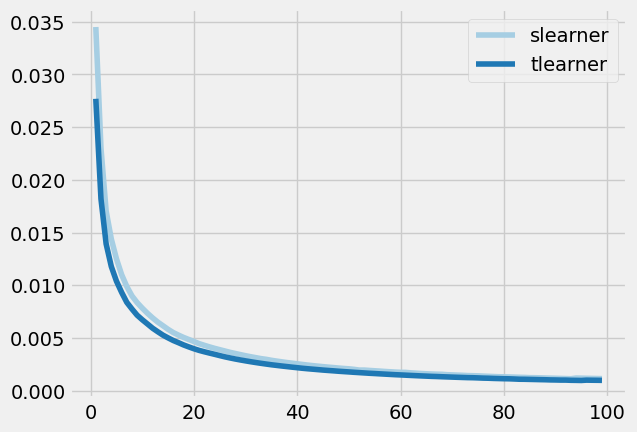

In [16]:
cv_df.plot()

In [17]:
timer.to_csv(pathlinker.prediction / "metalearner_duration.csv")